In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [5]:
data = pd.read_csv('processed_cardio_train.csv')
data.shape

(68764, 12)

# Preprocessing

## Impossible value removal → already done in EDA

# Clipping → apply carefully to extreme but valid values; decide ranges based on domain knowledge. (done)

## Feature engineering → create features that give the model more signal:

For cardio: BMI, age in years, BP difference, ratios, interaction features.

Think like a doctor: “what combination of features indicates risk?”

In [6]:
# lets add BMI, bp_diff,
# age_ap_hi : cardiovascular stress increases with age + high BP
def featureEng(data):
    data['bmi'] = data['weight'] / ((data['height'] / 100) ** 2)
    data['bp_diff'] = data['ap_hi'] - data['ap_lo']
    data['age_ap_hi'] = data['age'] * data['ap_hi']
    return data
data = featureEng(data)

In [7]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp_diff,age_ap_hi
0,50.357290,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30,5539.301848
1,55.381246,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50,7753.374401
2,51.627652,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60,6711.594798
3,48.249144,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50,7237.371663
4,47.841205,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40,4784.120465


## Scaling → use StandardScaler (if using LR, KNN, SVM, NN). 
Make sure you fit only on training data and transform both train/test using the same scaler.

scaling : adjusts feature magnitudes so no feature dominates a model purely because of its unit or numeric range
we can skip it for tree based algo, cause they work with value not its unit.

In [8]:
# creating function for common task among training and testing
def cliping(data):
    data['height'] = data['height'].clip(120, 220)
    data['weight'] = data['weight'].clip(30, 200)
    data['ap_hi'] = data['ap_hi'].clip(90, 240)
    data['ap_lo'] = data['ap_lo'].clip(60, 140)
    return data


# Model Selection & Training

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [10]:
x = data[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol','gluc', 'smoke', 'alco', 'active','bmi', 'bp_diff','age_ap_hi']]

In [11]:
y = data['cardio']

In [12]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=42)

In [13]:
# lets use random forest as model
model = RandomForestClassifier(n_estimators=100,max_depth=7,min_samples_split=5,min_samples_leaf=3,max_features='sqrt')

In [14]:
model.fit(xtrain,ytrain)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [16]:
ypred = model.predict(xtest)

In [15]:
model.score(xtest,ytest)

0.7368880271449345

# Hyperparameter Tuning

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [29]:
param_dist = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [30]:
model_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="recall",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [31]:
model_search.fit(xtrain, ytrain)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


d:\college\semester\btech 6\MLDL\ml_project_cardio\mlenv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...mples_split=5)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used he

In [33]:
model_best = model_search.best_estimator_

print("Best Parameters:")
print(model_search.best_params_)



Best Parameters:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [34]:
y_pred = model_best.predict(xtest)

print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))

[[7857 2633]
 [3065 7075]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.73     10490
           1       0.73      0.70      0.71     10140

    accuracy                           0.72     20630
   macro avg       0.72      0.72      0.72     20630
weighted avg       0.72      0.72      0.72     20630



# Model Evaluation (on baseline model)

In [25]:
cm = confusion_matrix(ytest,ypred)
cm

array([[8293, 2197],
       [3231, 6909]])

In [26]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75     10490
           1       0.76      0.68      0.72     10140

    accuracy                           0.74     20630
   macro avg       0.74      0.74      0.74     20630
weighted avg       0.74      0.74      0.74     20630



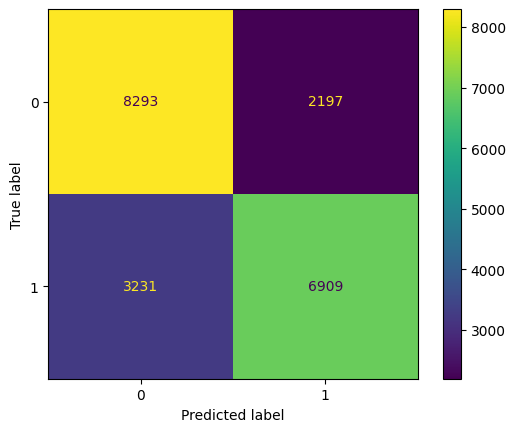

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

# Prediction

In [35]:
# In the UI

# storing the model

In [36]:
import pickle

In [37]:
with open('model.pkl','wb') as file:
    pickle.dump(model_best,file)